# PL11 .- QUANTUM NEURAL NETWORKS

En este notebook, vamos a mostrar cómo se pueden construir redes neuronales cuánticas integrando *PennyLane* con *Keras*.

Comenzamos importando las librerías necesarias y fijando las semillas de los generadores aleatorios.


In [1]:
# !pip install pennylane
# !pip install tensorflow==2.15
# !pip install silence_tensorflow

import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import pennylane as qml
import random
import os

os.environ['PYTHONHASHSEED']='0'

rs = 12345  # Semilla aleatoria

random.seed(rs)
np.random.seed(rs)
tf.random.set_seed(rs)

from silence_tensorflow import silence_tensorflow
silence_tensorflow()

Creamos un conjunto de datos sencillo y los dividimos en entrenamiento y test.

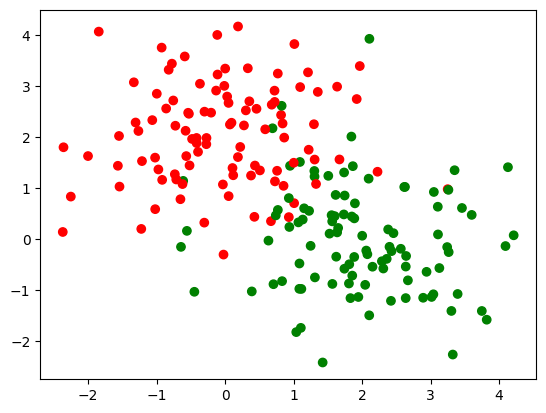

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=200, centers = [[0,2],[2,0]], random_state = rs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=rs)
plt.scatter(X[:, 0], X[:, 1], c = y, cmap=matplotlib.colors.ListedColormap(["red","green"]));

Como vamos a usar *angle embedding*, escalamos los datos al intervalo $[0,\pi]$.

In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,np.pi))
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## REDES NEURONALES CUÁNTICAS

Definimos un circuito que entrenaremos para crear nuestra red neuronal cuántica. Como *feature map* usamos *angle embedding* (https://docs.pennylane.ai/en/stable/code/api/pennylane.AngleEmbedding.html) y como forma variacional utilizamos *BasicEntanglerLayers* (https://docs.pennylane.ai/en/stable/code/api/pennylane.BasicEntanglerLayers.html). Finalmente, medimos para comprobar si el primer qubit es 0 o 1.

Ya que el conjunto de datos tiene dos atributos, usamos dos qubits.  

In [4]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    # Probablilidad de que el primer qubit sea un 0 o un 1
    state_0 = [[1], [0]]
    y = state_0 * np.conj(state_0).T
    return [qml.expval(qml.Hermitian(y, wires=[0]))]

Para poder conectar *PennyLane* con *Keras* usamos *KerasLayer*, a la que debemos pasar un argumento *weight_shapes* con el formato de los parámetros de la forma variacional (los parámetros que se entrenarán).

Probamos primero con una sola repetición de la forma variacional (*n_layers=1*).

In [5]:
n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

Construímos un modelo de Keras que tiene como única capa el circuito cuántico definido arriba. Para que el entrenamiento no sea excesivamente lento, aumentamos el *learning rate* hata 0.05.

In [6]:
model = tf.keras.models.Sequential([qlayer])
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

Entrenamos durante 100 épocas con *early stopping*.

In [7]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 0s 20ms/step - loss: 1.9052 - accuracy: 0.4766 - val_loss: 2.2637 - val_accuracy: 0.5000
Epoch 2/100
4/4 [==============================] - 0s 15ms/step - loss: 1.5954 - accuracy: 0.5000 - val_loss: 1.9583 - val_accuracy: 0.5312
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 1.2774 - accuracy: 0.5156 - val_loss: 1.4423 - val_accuracy: 0.5312
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 1.0560 - accuracy: 0.5312 - val_loss: 1.2353 - val_accuracy: 0.5312
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.9423 - accuracy: 0.5547 - val_loss: 1.1158 - val_accuracy: 0.5625
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8475 - accuracy: 0.5859 - val_loss: 1.0616 - val_accuracy: 0.5625
Epoch 7/100
4/4 [==============================] - 0s 15ms/step - loss: 0.8077 - accuracy: 0.6016 - val_loss: 1.1341 - val_accuracy: 0.5625
Epoch 8/100
4/4 [===

2/2 [==============================] - 0s 8ms/step - loss: 0.6242 - accuracy: 0.6250


[0.6241772174835205, 0.625]

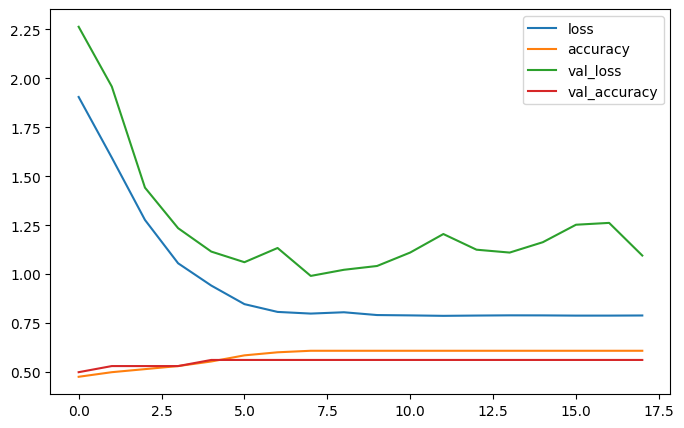

In [8]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))

model.evaluate(X_test, y_test)

Los resultados son malos, pero es que el modelo sólo tiene dos parámetros.

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2)                 2         
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Probamos ahora con dos repeticiones de la forma variacional.

In [11]:
model = tf.keras.models.Sequential([qlayer])
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [12]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 0s 24ms/step - loss: 1.7069 - accuracy: 0.3203 - val_loss: 1.4435 - val_accuracy: 0.4062
Epoch 2/100
4/4 [==============================] - 0s 19ms/step - loss: 1.4548 - accuracy: 0.2578 - val_loss: 1.2454 - val_accuracy: 0.3438
Epoch 3/100
4/4 [==============================] - 0s 19ms/step - loss: 1.2837 - accuracy: 0.2266 - val_loss: 1.1098 - val_accuracy: 0.2812
Epoch 4/100
4/4 [==============================] - 0s 19ms/step - loss: 1.1499 - accuracy: 0.2109 - val_loss: 1.0060 - val_accuracy: 0.3125
Epoch 5/100
4/4 [==============================] - 0s 19ms/step - loss: 1.0364 - accuracy: 0.1953 - val_loss: 0.9205 - val_accuracy: 0.3125
Epoch 6/100
4/4 [==============================] - 0s 19ms/step - loss: 0.9425 - accuracy: 0.1953 - val_loss: 0.8478 - val_accuracy: 0.2812
Epoch 7/100
4/4 [==============================] - 0s 19ms/step - loss: 0.8584 - accuracy: 0.1875 - val_loss: 0.7864 - val_accuracy: 0.2812
Epoch 8/100
4/4 [===

2/2 [==============================] - 0s 10ms/step - loss: 0.3525 - accuracy: 0.8750


[0.3524762988090515, 0.875]

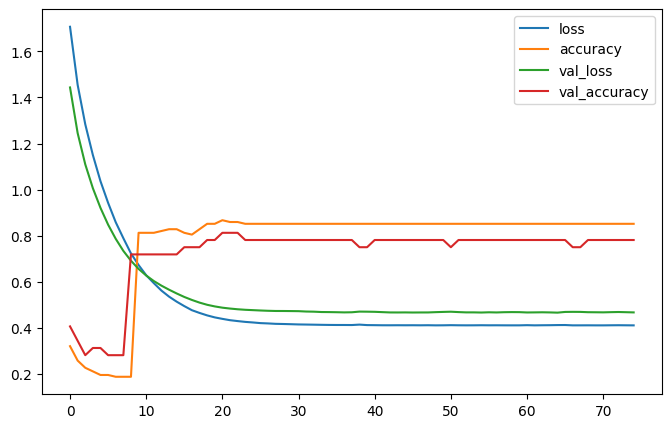

In [13]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 2)                 4         
                                                                 
Total params: 4 (16.00 Byte)
Trainable params: 4 (16.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Probemos a cambiar el tipo de forma variacional a *StronglyEntanglingLayers* (https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html).

Nótese que ahora tenemos 3 parámetros por cada puerta de rotación.  

In [15]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    state_0 = [[1], [0]]
    y = state_0 * np.conj(state_0).T
    return [qml.expval(qml.Hermitian(y, wires=[0]))]

n_layers = 1
weight_shapes = {"weights": (n_layers, n_qubits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model = tf.keras.models.Sequential([qlayer])
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [16]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 0s 25ms/step - loss: 0.4894 - accuracy: 0.7266 - val_loss: 0.3906 - val_accuracy: 0.8438
Epoch 2/100
4/4 [==============================] - 0s 25ms/step - loss: 0.4628 - accuracy: 0.7812 - val_loss: 0.3866 - val_accuracy: 0.8125
Epoch 3/100
4/4 [==============================] - 0s 21ms/step - loss: 0.4517 - accuracy: 0.8125 - val_loss: 0.3879 - val_accuracy: 0.8125
Epoch 4/100
4/4 [==============================] - 0s 20ms/step - loss: 0.4510 - accuracy: 0.8359 - val_loss: 0.3886 - val_accuracy: 0.8438
Epoch 5/100
4/4 [==============================] - 0s 32ms/step - loss: 0.4516 - accuracy: 0.8359 - val_loss: 0.3888 - val_accuracy: 0.8438
Epoch 6/100
4/4 [==============================] - 0s 20ms/step - loss: 0.4524 - accuracy: 0.8359 - val_loss: 0.3882 - val_accuracy: 0.8125
Epoch 7/100
4/4 [==============================] - 0s 20ms/step - loss: 0.4506 - accuracy: 0.8359 - val_loss: 0.3883 - val_accuracy: 0.8125
Epoch 8/100
4/4 [===

2/2 [==============================] - 0s 10ms/step - loss: 0.2523 - accuracy: 0.9250


[0.2523384988307953, 0.925000011920929]

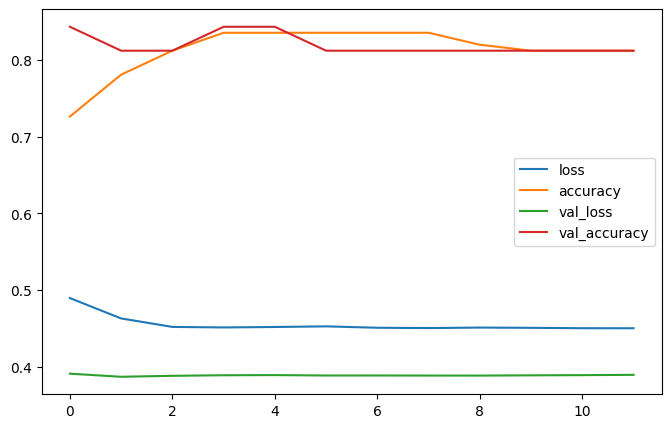

In [17]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 2)                 6         
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Ahora, con dos repeticiones de la forma variacional.

In [19]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    state_0 = [[1], [0]]
    y = state_0 * np.conj(state_0).T
    return [qml.expval(qml.Hermitian(y, wires=[0]))]

n_layers = 2
weight_shapes = {"weights": (n_layers, n_qubits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model = tf.keras.models.Sequential([qlayer])
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [20]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 0s 32ms/step - loss: 0.8717 - accuracy: 0.4375 - val_loss: 0.6861 - val_accuracy: 0.4375
Epoch 2/100
4/4 [==============================] - 0s 30ms/step - loss: 0.6852 - accuracy: 0.5859 - val_loss: 0.5647 - val_accuracy: 0.7500
Epoch 3/100
4/4 [==============================] - 0s 31ms/step - loss: 0.5636 - accuracy: 0.7656 - val_loss: 0.4719 - val_accuracy: 0.8438
Epoch 4/100
4/4 [==============================] - 0s 30ms/step - loss: 0.4696 - accuracy: 0.8281 - val_loss: 0.4032 - val_accuracy: 0.9062
Epoch 5/100
4/4 [==============================] - 0s 29ms/step - loss: 0.3982 - accuracy: 0.8672 - val_loss: 0.3652 - val_accuracy: 0.8750
Epoch 6/100
4/4 [==============================] - 0s 29ms/step - loss: 0.3581 - accuracy: 0.9062 - val_loss: 0.3555 - val_accuracy: 0.9062
Epoch 7/100
4/4 [==============================] - 0s 31ms/step - loss: 0.3484 - accuracy: 0.8828 - val_loss: 0.3610 - val_accuracy: 0.9062
Epoch 8/100
4/4 [===

2/2 [==============================] - 0s 12ms/step - loss: 0.2075 - accuracy: 0.9750


[0.20747125148773193, 0.9750000238418579]

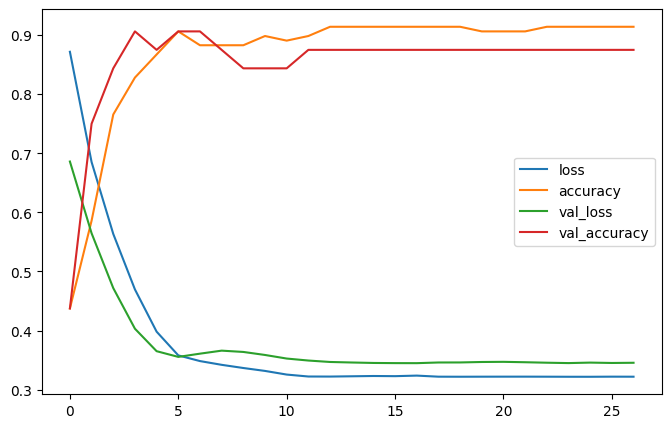

In [21]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [22]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2)                 12        
                                                                 
Total params: 12 (48.00 Byte)
Trainable params: 12 (48.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## EJERCICIO

Crear una red cuántica para un problema de clasificación binaria con 4 variables de entrada. ¿Cuántos qubits tienes que usar en la capa cuántica?

In [39]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    state_0 = [[1], [0]]
    y = state_0 * np.conj(state_0).T
    return [qml.expval(qml.Hermitian(y, wires=[0]))]

n_layers = 4
weight_shapes = {"weights": (n_layers, n_qubits,3)}
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model = tf.keras.models.Sequential([qlayer])
opt = tf.keras.optimizers.Adam(learning_rate=0.05)
model.compile(loss='binary_crossentropy', optimizer = opt, metrics=["accuracy"])

In [40]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.2, callbacks=[early_stopping_cb])

Epoch 1/100
4/4 [==============================] - 0s 48ms/step - loss: 0.4674 - accuracy: 0.7656 - val_loss: 0.3601 - val_accuracy: 0.8750
Epoch 2/100
4/4 [==============================] - 0s 44ms/step - loss: 0.3863 - accuracy: 0.8594 - val_loss: 0.3439 - val_accuracy: 0.9062
Epoch 3/100
4/4 [==============================] - 0s 47ms/step - loss: 0.3518 - accuracy: 0.8828 - val_loss: 0.3428 - val_accuracy: 0.9062
Epoch 4/100
4/4 [==============================] - 0s 46ms/step - loss: 0.3486 - accuracy: 0.8906 - val_loss: 0.3376 - val_accuracy: 0.9062
Epoch 5/100
4/4 [==============================] - 0s 44ms/step - loss: 0.3338 - accuracy: 0.8984 - val_loss: 0.3452 - val_accuracy: 0.8438
Epoch 6/100
4/4 [==============================] - 0s 43ms/step - loss: 0.3377 - accuracy: 0.8828 - val_loss: 0.3488 - val_accuracy: 0.8750
Epoch 7/100
4/4 [==============================] - 0s 43ms/step - loss: 0.3394 - accuracy: 0.8906 - val_loss: 0.3367 - val_accuracy: 0.8750
Epoch 8/100
4/4 [===

2/2 [==============================] - 0s 22ms/step - loss: 0.2057 - accuracy: 0.9750


[0.20574717223644257, 0.9750000238418579]

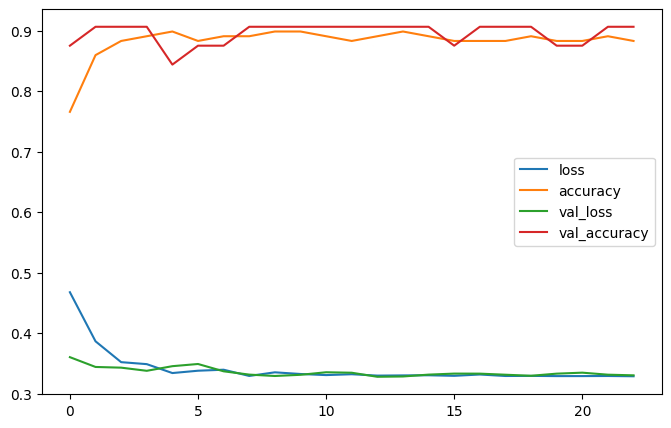

In [41]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5));

model.evaluate(X_test, y_test)

In [42]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_8 (KerasLayer)  (None, 2)                 24        
                                                                 
Total params: 24 (96.00 Byte)
Trainable params: 24 (96.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
